# Sampling Example

## Theory

Here some theory before the programming stuff


In [7]:
# in case of dask

#from dask.distributed import Client
#client = Client()

# load libraries for datacube, plotting and stuff

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import fsspec

# The correlation function we will use

import scipy.spatial.distance as ssd

import importlib.metadata
#importlib.metadata.version('matplotlib')

In [8]:
# function to calculate the distance of coordinates in km
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # radius of the earth in km
    phi1, phi2 = np.radians([lat1, lat2])
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi / 2.) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2.) ** 2
    return 2 * R * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

In [9]:
# extreme cube from Jena
#extremes_url= "https://s3.bgc-jena.mpg.de:9000/deepextremes/v2/labelcube_ranked_pot0.01_ne0.1_cmp_2016_2021.zarr"
#extremes_cube = xr.open_zarr(fsspec.get_mapper(extremes_url), consolidated=True)

# ERA5 cube
era5_url = "D:/ERA5Data.zarr"
era5_cube = xr.open_zarr(fsspec.get_mapper(era5_url ), consolidated=True)

# ESDC v3.0.2 cube
esdc302_url = "D:/DataCube/v3.0.2/esdc-8d-0.25deg-1x720x1440-3.0.2.zarr"
esdc302_cube = xr.open_zarr(esdc302_url, consolidated=True)

# slicing time to event time and reference time
time_event = slice("2018-06-01", "2018-08-31")
time_reference = slice("2002-01-01", "2017-12-31")

# load data for event and reference time and convert to Celsius
#datacube_event = era5_cube.t2m.sel(latitude=slice(60, 30), longitude=slice(0, 40), time=time_event) - 273.15
#datacube_reference = era5_cube.t2m.sel(latitude=slice(60, 30), longitude=slice(0, 40), time=time_reference) - 273.15
datacube_reference = esdc302_cube.kndvi.sel(lat=slice(30,60), lon=slice(0,40), time=time_reference).rename({'lat':'latitude','lon':'longitude'})
datacube_event = esdc302_cube.kndvi.sel(lat=slice(30,60), lon=slice(0,40), time=time_event).rename({'lat':'latitude','lon':'longitude'})
# number of time steps in reference and event time
n_time_reference = len(datacube_reference.time)
n_time_event = len(datacube_event.time)

# load the sampling points for event and non-event from CSV
locations_event = pd.read_csv("./lc_subset_event.csv")[['Latitude','Longitude','OutsideEvent','Class']]
locations_non_event = pd.read_csv("./lc_subset_nonevent.csv")[['Latitude','Longitude','OutsideEvent','Class']]

In [10]:
# concat the event and non-event locations to single table
locations = pd.concat([locations_event, locations_non_event])
# use classes as integers and convert them to categorical
locations['Class'] = locations['Class'].astype(int)
mappings = {
    1: 'Forest',
    2: 'Grassland',
    3: 'Cropland',
    4: 'Wetland',
    5: 'Artificial Surface',
    6: 'Bareland',
    7: 'Water'
}
locations['Class'] = locations['Class'].map(mappings)
locations.reset_index(drop=True, inplace=True)
print(locations) 

       Latitude  Longitude  OutsideEvent               Class
0     59.956944  13.184722         False             Wetland
1     59.956944  17.718056         False             Wetland
2     59.831944  10.768056         False             Wetland
3     59.831944  15.184722         False             Wetland
4     59.706944  12.684722         False             Wetland
...         ...        ...           ...                 ...
1798  30.351389  26.493056          True  Artificial Surface
1799  30.226389   1.751389          True  Artificial Surface
1800  30.226389  26.243056          True  Artificial Surface
1801  30.101389   0.876389          True  Artificial Surface
1802  30.101389   1.876389          True  Artificial Surface

[1803 rows x 4 columns]


437
Number of entries before Nan Filtering: 437
Number of entries after Nan Filtering: 437


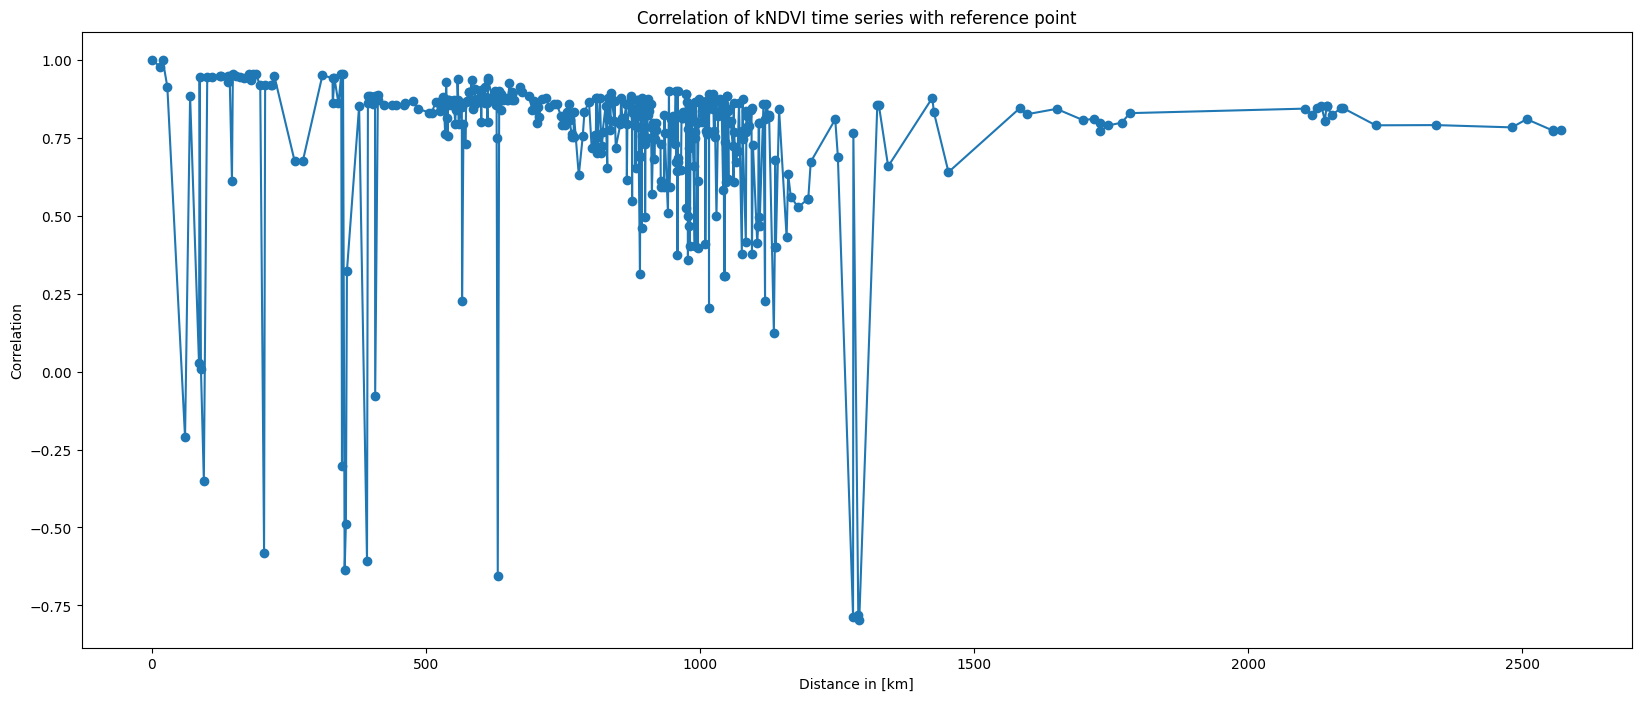

In [11]:
# Analize evertything relative to a position or subgroup
relative_locations = locations[locations.Class == 'Forest'].copy()
#relative_locations = locations.copy()
relative_locations.reset_index(drop=True, inplace=True)
print(len(relative_locations))

position_number = 112
position = pd.Series({
    'Latitude': relative_locations.Latitude[position_number],
    'Longitude': relative_locations.Longitude[position_number]})

relative_locations['Distance'] = relative_locations.apply(lambda row: haversine(position.Latitude, position.Longitude, row.Latitude, row.Longitude), axis=1)
relative_locations.sort_values(by='Distance', inplace=True)
relative_locations.reset_index(drop=True, inplace=True)
#print(relative_locations)

# load the reference cube into memory
datacube_reference.load()
# collect all time series data for the locations
data_relative = [datacube_reference.sel(latitude=row.Latitude, longitude=row.Longitude, method='nearest').dropna('time').values for row in relative_locations.itertuples()]
# remove relative_locations with less entries
print('Number of entries before Nan Filtering: ' + str(len(data_relative)))
for loc in reversed(range(len(data_relative))):
    if data_relative[loc].shape[0] < n_time_reference:
        #print("Location " + str(loc) + " has only " + str(data_relative[loc].shape[0]) + " entries")
        relative_locations.drop(loc, inplace=True)
        data_relative.pop(loc)
print('Number of entries after Nan Filtering: ' + str(len(data_relative)))
data_relative = np.array(data_relative)

# calculate the correlation matrix
corr_matrix = np.corrcoef(data_relative)

plt.figure(figsize=(20,8))
plt.plot(relative_locations.Distance,corr_matrix[0], 'o-')
plt.xlabel('Distance in [km]')
plt.ylabel('Correlation')
plt.title('Correlation of kNDVI time series with reference point')
plt.show()

Text(0.5, 1.0, 'Correlation of kNDVI time series with reference point')

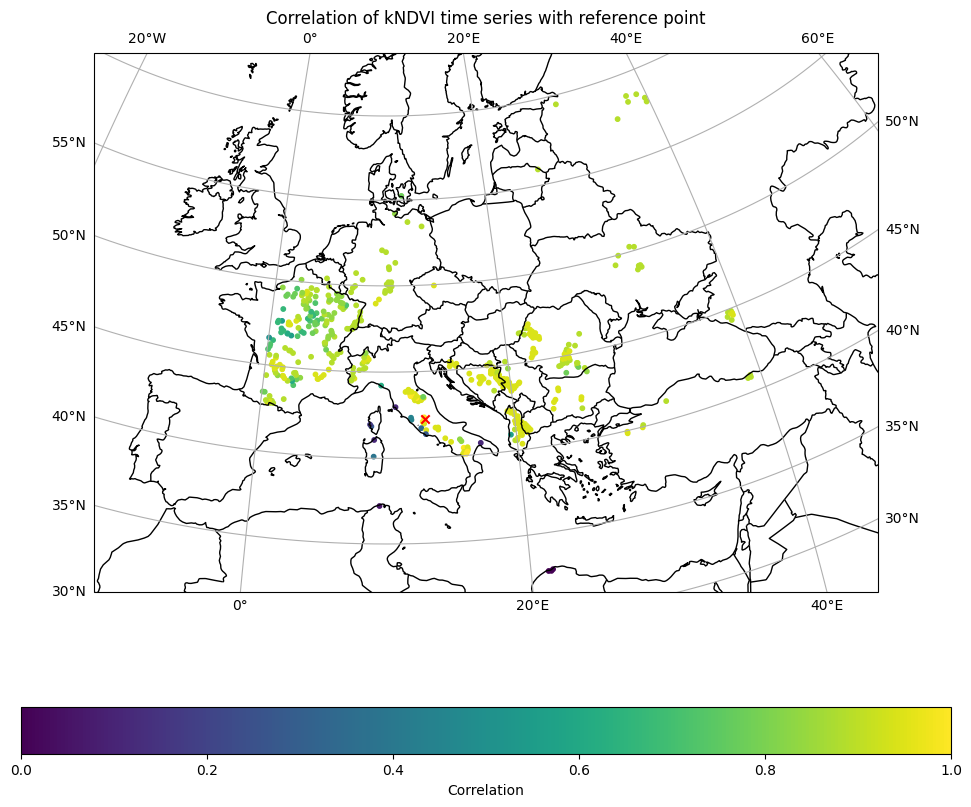

In [12]:
figure = plt.figure(figsize=(12,10))
ax = figure.add_subplot(1,1,1, projection=ccrs.Orthographic(10,45))
ax.set_extent([-10, 45, 30, 60], crs=ccrs.PlateCarree())
#ax.stock_img()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)
ax.gridlines(draw_labels=True)

colormap = plt.cm.nipy_spectral #I suggest to use nipy_spectral


plt.scatter(relative_locations.Longitude, relative_locations.Latitude, c=np.round(corr_matrix[0],1), transform=ccrs.PlateCarree(), s=10)
plt.scatter(position.Longitude, position.Latitude, c='red', marker='x', transform=ccrs.PlateCarree())

plt.colorbar(label='Correlation', orientation='horizontal')
plt.title('Correlation of kNDVI time series with reference point')
